In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [6]:
# INSTRUCTIONS: first import the zip file with the classes, then uncomment and run the unzip. Then don't forget to comment it again!
#!unzip Classes.zip
# You might need to install some libraries. You can do as foolows:
#!pip install datasets

In [7]:
# Define data augmentation transformations
transformation = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the dataset
dataset = ImageFolder('Classes', transform=transformation)

# Split the dataset into training, validation, and test sets
train_size = int(0.65 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

# Create data loaders for training, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


Train set size: 499
Validation set size: 192
Test set size: 77


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x


class Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, num_epochs):
        train_losses = []
        val_losses = []
        val_accuracies = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            self.model.train()

            for i, data in enumerate(self.train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            train_loss = running_loss / len(self.train_loader)
            train_losses.append(train_loss)

            val_loss, val_accuracy = self.evaluate(self.val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {val_accuracy:.2f}%")

        self.plot_metrics(train_losses, val_losses, val_accuracies)

        print("Training finished.")

    def evaluate(self, data_loader):
        self.model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for data in data_loader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        average_loss = total_loss / len(data_loader)
        accuracy = (100.0 * total_correct) / total_samples

        return average_loss, accuracy

    def test(self):
        test_loss, test_accuracy = self.evaluate(self.test_loader)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    @staticmethod
    def plot_metrics(train_losses, val_losses, val_accuracies):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'b-', label='Training Loss')
        plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_accuracies, 'g-')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self):
        true_labels = []
        predicted_labels = []

        self.model.eval()
        with torch.no_grad():
            for data in self.test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        cm = confusion_matrix(true_labels, predicted_labels)

        classes = dataset.classes
        num_classes = len(classes)

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        thresh = cm.max() / 2
        for i in range(num_classes):
            for j in range(num_classes):
                plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

Epoch 1, Training Loss: 0.9488, Validation Loss: 0.7168, Validation Accuracy: 61.98%
Epoch 2, Training Loss: 0.6784, Validation Loss: 0.5646, Validation Accuracy: 71.88%
Epoch 3, Training Loss: 0.5216, Validation Loss: 0.4262, Validation Accuracy: 81.25%
Epoch 4, Training Loss: 0.4323, Validation Loss: 0.5237, Validation Accuracy: 72.40%
Epoch 5, Training Loss: 0.3839, Validation Loss: 0.3355, Validation Accuracy: 88.02%
Epoch 6, Training Loss: 0.3155, Validation Loss: 0.2864, Validation Accuracy: 86.98%
Epoch 7, Training Loss: 0.2378, Validation Loss: 0.2658, Validation Accuracy: 89.06%
Epoch 8, Training Loss: 0.2152, Validation Loss: 0.2280, Validation Accuracy: 89.58%
Epoch 9, Training Loss: 0.2289, Validation Loss: 0.2928, Validation Accuracy: 88.02%
Epoch 10, Training Loss: 0.2168, Validation Loss: 0.2203, Validation Accuracy: 88.54%


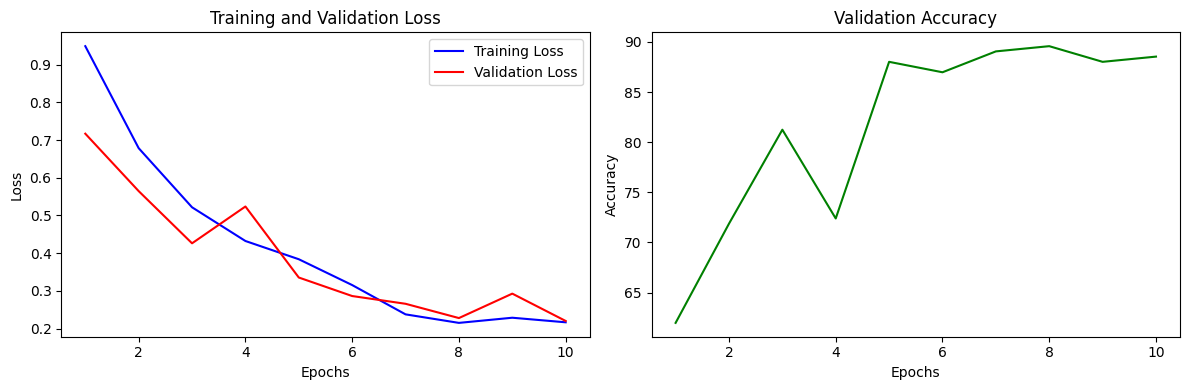

Training finished.
Test Loss: 0.1627, Test Accuracy: 96.10%


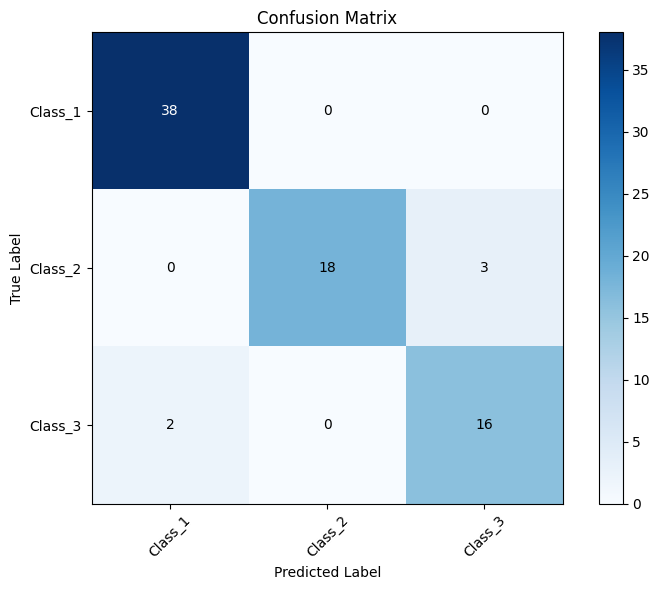

In [9]:
# Create an instance of the network
net = Net()

# Create an instance of the Trainer and start training
trainer = Trainer(net, train_loader, val_loader, test_loader)
trainer.train(num_epochs=10)

# Evaluate on the test set
trainer.test()

# Plot the confusion matrix
trainer.plot_confusion_matrix()